<a href="https://colab.research.google.com/github/ML-HW-SYS/a0-anya-23-ct/blob/main/a0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Git and Drive Integration

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import time

In [2]:
import matplotlib.pyplot as plt
import numpy as np

### Mount google drive

In [3]:
# Mount google drive to use a persistent directory structure
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Clone the assignment repository

In [ ]:
# Create a directory for the course
%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545

# Create files to hold your Github token and username.
!echo 'YOUR_TOKEN' > /content/gdrive/MyDrive/ece5545/token.txt
!echo 'YOUR_HANDLE' > /content/gdrive/MyDrive/ece5545/git_username.txt

# TODO: Navigate to the created files and replace the contents with your token and username.
# Do NOT place your token inside of the notebook. This way there is no risk that you will push it to your repo.
# Never share your token with anyone, it is basically your github password!

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545


In [ ]:
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

YOUR_TOKEN = token
YOUR_HANDLE = handle

!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a0-{YOUR_HANDLE}.git a0

fatal: destination path 'a0' already exists and is not an empty directory.


### Add `src` directory to the Python import path

In [4]:
# import functions from the src directory in repo
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/ece5545/a0/src')

### Import functions from `src/train_utils.py`

In [5]:
import train_utils
from model import *

### Make changes to `src` files and push to repo

In [6]:
# You will likely need to set your git user identification settings
!git config --global user.email "ad2258@cornell.edu"  # update with your email
!git config --global user.name "ANANYA DAS"   # update with your name

In [7]:
# To run the same tests that are run on Github Classroom
%cd /content/gdrive/MyDrive/ece5545/a0
!python3 -m pytest

/content/gdrive/MyDrive/ece5545/a0
======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.4.0
rootdir: /content/gdrive/MyDrive/ece5545/a0
plugins: anyio-3.7.1
collected 1 item                                                                                   

tests/test_model.py .                                                                        [100%]

======================================== 1 passed in 1.78s =========================================


In [ ]:
# %cd /content/gdrive/MyDrive/ece5545/a0/src
# # Navigate to a0/src/model.py and fix the bug (denoted by TODO)
# # in the file then commit the changes below
# !git commit -am "fixed bug in model.py"
# !git push

## Training Configuration

In [8]:
batch_size = 128
epochs = 5
lr = 1.0
gamma = 0.7
# no_cuda = False
seed = 42
log_interval = 50
save_model = False
dry_run = False

# Derived parameters
# use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)

def set_kwargs(batch_size, use_cuda):
  device = torch.device("cuda" if use_cuda else "cpu")
  train_kwargs = {'batch_size': batch_size}
  test_kwargs = {'batch_size': batch_size}
  if use_cuda:
      cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
      train_kwargs.update(cuda_kwargs)
      test_kwargs.update(cuda_kwargs)
  return device, train_kwargs, test_kwargs

## Data Loaders and Optimizer Setup

In [9]:
def dataloaders_and_optimizer_setup(train_kwargs, test_kwargs):
  transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])
  dataset1 = datasets.MNIST('/content/gdrive/MyDrive/ece5545/data', train=True, download=True,
                      transform=transform)
  dataset2 = datasets.MNIST('/content/gdrive/MyDrive/ece5545/data', train=False,
                        transform=transform)
  train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
  test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

  model = Net().to(device)
  optimizer = optim.Adadelta(model.parameters(), lr=lr)

  scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

  return train_loader, test_loader, model, optimizer, scheduler

## Training Loop

In [10]:
import importlib
importlib.reload(train_utils)
# we use importlib to make sure that we are loading
# the latest version of train_utils after any changes
# that you may have done

def run_model (use_cuda, epochs, model, device, train_loader, optimizer, log_interval, dry_run, test_loader, scheduler):

  # use_cuda = not no_cuda and torch.cuda.is_available()
  # device = torch.device("cuda" if use_cuda else "cpu")

  time_array = []
  for epoch in range(1, epochs + 1):
      train_time = train_utils.train(model, device, train_loader, optimizer, epoch, log_interval, dry_run)
      time_array.append(train_time)
      train_utils.test(model, device, test_loader)
      scheduler.step()

  if save_model:
      torch.save(model.state_dict(), "mnist_cnn.pt")

  return time_array

In [11]:
# Diagnostic information about the used GPU device
!nvidia-smi

Mon Feb  5 13:30:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
def print_time_info(device,batch,lst):
  np_time = np.array(lst)
  avg_time = np.mean(np_time)
  stddev_time = np.std(np_time)
  print('For device {}, batch_size of {}, average training time per epoch was {} and standard deviation was {}'.format(device,batch_size, round(avg_time,3), round(stddev_time,3)))

In [13]:
def collate_time_info(times):
  mean_times = []
  stddev_times = []
  for time_array in times:
    avg_time = np.mean(time_array)
    stddev_time = np.std(time_array)
    mean_times.append(avg_time)
    stddev_times.append(stddev_time)
  return mean_times, stddev_times

In [14]:
batch_sizes = [64,128,256,512,1024]
gpu_times = []

In [15]:
%pwd

'/content/gdrive/MyDrive/ece5545/a0'

In [16]:
# %%capture captured_output

for batch_size in batch_sizes:
  print('batch_size is {} \n'.format(batch_size))
  device, cur_train_kwargs, cur_test_kwargs = set_kwargs(batch_size, True)
  cur_train_loader, cur_test_loader, cur_model, cur_optimizer, cur_scheduler = dataloaders_and_optimizer_setup(cur_train_kwargs, cur_test_kwargs)
  gpu_time = run_model(True, epochs, cur_model, device, cur_train_loader, cur_optimizer, log_interval, dry_run, cur_test_loader, cur_scheduler)
  gpu_times.append(gpu_time)

# with open('/content/gdrive/My Drive/ece5545/a0/gpu_train_output.txt', 'w') as f:
#     f.write(captured_output.stdout)

batch_size is 64 

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302757
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.644664
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.354379
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.262398
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.274490
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.139873
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.071340
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.060818
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.160247
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.078773
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.145625
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.238767
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.046549
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.081222
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.058807
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.040978
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.052664
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.107152
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.108867

Epoch 1 time = 19.39s on device cuda

T

In [17]:
gpu_mean_times, gpu_stddev_times = collate_time_info(gpu_times)

In [18]:
# device = torch.device("cpu")
# use_cuda = False
cpu_times = []

In [19]:
# %%capture captured_output

for batch_size in batch_sizes:
  print('batch_size is {} \n'.format(batch_size))
  device, cur_train_kwargs, cur_test_kwargs = set_kwargs(batch_size, False)
  cur_train_loader, cur_test_loader, cur_model, cur_optimizer, cur_scheduler = dataloaders_and_optimizer_setup(cur_train_kwargs, cur_test_kwargs)
  cpu_time = run_model(False, epochs, cur_model, device, cur_train_loader, cur_optimizer, log_interval, dry_run, cur_test_loader, cur_scheduler)
  cpu_times.append(cpu_time)

# with open('/content/gdrive/My Drive/ece5545/a0/gpu_train_output.txt', 'w') as f:
#     f.write(captured_output.stdout)

batch_size is 64 

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295828
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.158575
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.298950
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.170954
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.160294
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.208553
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.301717
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.124233
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.070802
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.093668
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.213542
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.165648
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.063000
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.146439
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.217108
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.099363
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.245829
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.113811
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.072222

Epoch 1 time = 145.61s on device cpu

T

In [20]:
cpu_mean_times, cpu_stddev_times = collate_time_info(cpu_times)

In [26]:
# %%capture captured_output

devc = 'GPU'
for batch_size, gpu_time in zip(batch_sizes,gpu_times):
  print_time_info(devc,batch_size,gpu_time)

devc = 'CPU'
for batch_size, cpu_time in zip(batch_sizes,cpu_times):
  print_time_info(devc,batch_size,cpu_time)

# captured_output.stdout

For device GPU, batch_size of 64, average training time per epoch was 18.436 and standard deviation was 0.704
For device GPU, batch_size of 128, average training time per epoch was 16.236 and standard deviation was 0.468
For device GPU, batch_size of 256, average training time per epoch was 15.498 and standard deviation was 0.413
For device GPU, batch_size of 512, average training time per epoch was 14.978 and standard deviation was 0.972
For device GPU, batch_size of 1024, average training time per epoch was 13.792 and standard deviation was 0.152
For device CPU, batch_size of 64, average training time per epoch was 152.29 and standard deviation was 3.549
For device CPU, batch_size of 128, average training time per epoch was 135.024 and standard deviation was 1.612
For device CPU, batch_size of 256, average training time per epoch was 166.758 and standard deviation was 1.446
For device CPU, batch_size of 512, average training time per epoch was 176.192 and standard deviation was 1.287

In [22]:
# # Save captured output to a file
# with open('/content/gdrive/My Drive/ece5545/a0/train_times_print_output.txt', 'w') as f:
#     f.write(captured_output.stdout)

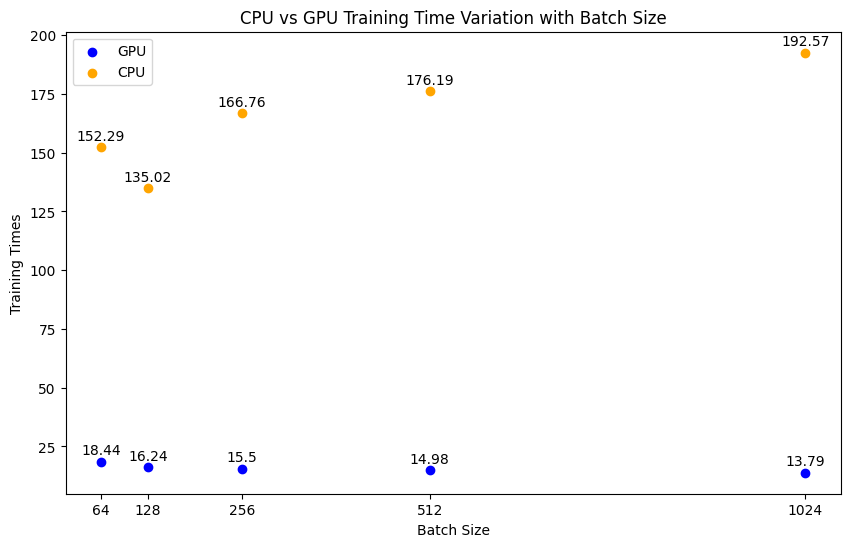

In [35]:
gpu_mean_times_rounded = []
cpu_mean_times_rounded = []

for i in range(len(batch_sizes)):
  gpu_mean_times_rounded.append(round(gpu_mean_times[i],2))
  cpu_mean_times_rounded.append(round(cpu_mean_times[i],2))

plt.figure(figsize=(10, 6))
plt.scatter(batch_sizes, gpu_mean_times, label='GPU', color='blue')
plt.scatter(batch_sizes, cpu_mean_times, label='CPU', color='orange')

for i, txt in enumerate(gpu_mean_times_rounded):
    plt.annotate(txt, (batch_sizes[i], gpu_mean_times_rounded[i]), textcoords="offset points", xytext=(0, 5), ha='center')
for i, txt in enumerate(cpu_mean_times_rounded):
    plt.annotate(txt, (batch_sizes[i], cpu_mean_times_rounded[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.xticks(batch_sizes)

plt.xlabel('Batch Size')
plt.ylabel('Training Times')
plt.title('CPU vs GPU Training Time Variation with Batch Size')
plt.legend()

plt.savefig('/content/gdrive/My Drive/ece5545/a0/annotated_output_plot.png')
plt.show()

In [36]:
# %cd /content/gdrive/MyDrive/ece5545/a0/src
# # Navigate to a0/src/model.py and fix the bug (denoted by TODO)
# # in the file then commit the changes below
# !git commit -am "fixed bug in model.py"
# !git push

! git status

Refresh index: 100% (7/7), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   src/train_utils.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	CPU_Training.gdoc
	GPU_Training.gdoc
	annotated_output_plot.png
	output_plot.png
	src/__pycache__/
	tests/__pycache__/
	train_times_print_output.txt

no changes added to commit (use "git add" and/or "git commit -a")


In [37]:
! git add src/train_utils.py

In [38]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   src/train_utils.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	CPU_Training.gdoc
	GPU_Training.gdoc
	annotated_output_plot.png
	output_plot.png
	src/__pycache__/
	tests/__pycache__/
	train_times_print_output.txt



In [39]:
%cd /content/gdrive/MyDrive/ece5545/a0/src

/content/gdrive/MyDrive/ece5545/a0/src


In [41]:
!git commit -am "updated train_utils.py for data collection"
!git push

[main 8aba040] updated train_utils.py for data collection
 1 file changed, 1 insertion(+)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 428 bytes | 71.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/ML-HW-SYS/a0-anya-23-ct.git
   9676b9d..8aba040  main -> main
